In [5]:
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

import itertools
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 600)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, svm, tree
from sklearn.ensemble import RandomForestRegressor
from  sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
#import swifter

np.random.seed(1907)

In [6]:
def initial_data_preparation():
    

    data = pd.read_csv("../data/interim/spark_processed_data.csv", sep="|")

    
    
    print(f"{len(data)} Rows.")
   

    multi_choice_columns = pd.read_csv("../data/interim/spark_multi_choice_columns.csv", sep="|")["0"].tolist()
    data = data.drop(multi_choice_columns, axis=1)
    
    #Outlier Handling
    # Age 90'dan büyükse sil
    data = data[data["Age"] <90]
    # WorkWeekHrs drop
    data = data.drop("WorkWeekHrs", axis=1)
    

    
    # Preserve country columns for target transformation
    data["Country_for_target_transformation"] = data["Country"]
    
    #Drop observations have less then $100 ConvertedComp and professional dev.
    data = data[(~(data["ConvertedComp"]<100) &  (data.MainBranch == "I am a developer by profession"))]

    #Drop observations have greater then $0.5M ConvertedComp
    data = data[data["ConvertedComp"]<=500000]
    
    #Use the data only from professional developers
    data = data[data.MainBranch == "I am a developer by profession"]
    
    # One hot encoding
    cat_columns = ["Country", "Gender", "JobSat", 
                                        "JobSeek",
                                        "Employment",
                                        "MainBranch", 
                                        "Hobbyist", 
                                        "EdLevel", 
                                        "NEWDevOps", 
                                        "NEWDevOpsImpt", 
                                        "NEWEdImpt", 
                                        "NEWLearn",
                                        "NEWOffTopic",
                                        "NEWOnboardGood",
                                        "NEWOtherComms",
                                        "NEWOvertime",
                                        "NEWPurpleLink","OpSys","OrgSize",
                                        "PurchaseWhat","SOAccount",
                                        "SOComm","SOPartFreq","SOVisitFreq",
                                        "SurveyEase", "SurveyLength","Trans", "UndergradMajor","WelcomeChange"]
    
    cat_columns = [col for col in cat_columns if col not in multi_choice_columns]
    data = pd.get_dummies(data=data, columns=cat_columns)

    
    data = data.dropna(subset=["ConvertedComp"], axis=0)
    data = data[data["ConvertedComp"] >0]
    
    #Drop countries that has less than 150 observation
    countries = data["Country_for_target_transformation"].value_counts()
    countries_to_drop = countries[countries <= 200].index.tolist()
    data = data[~data["Country_for_target_transformation"].isin(countries_to_drop)].reset_index(drop=True)
    
    
    print(f"{len(data)} Rows.")
    
    
    # Fill NaNs with median
    nas = data.isna().sum()
    nas = nas[nas > 0]

    for na_col in nas.index:
        data[na_col].fillna(data[na_col].median(), inplace=True)

    #LABEL :"ConvertedComp"
    return data

In [7]:
def load_processed_data(force_processing=False):
    if force_processing:
        data = initial_data_preparation()
        data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    else:
        try:
            data = pd.read_csv("../data/processed/processed_data.csv", sep="|")
        except Exception as e:
            print(e)
            data = initial_data_preparation()
            data.to_csv("../data/processed/processed_data.csv", sep="|", index=False)
    
    return data

data = load_processed_data(force_processing=True)

64461 Rows.
21934 Rows.


In [8]:
data.head()

,Age,Age1stCode,ConvertedComp,YearsCode,YearsCodePro,DatabaseDesireNextYear_MariaDB,DatabaseDesireNextYear_Microsoft SQL Server,DatabaseDesireNextYear_MongoDB,DatabaseDesireNextYear_MySQL,DatabaseDesireNextYear_Oracle,DatabaseDesireNextYear_PostgreSQL,DatabaseDesireNextYear_Redis,DatabaseDesireNextYear_SQLite,DatabaseDesireNextYear_Cassandra,DatabaseDesireNextYear_IBM DB2,DatabaseDesireNextYear_DynamoDB,DatabaseDesireNextYear_Elasticsearch,DatabaseDesireNextYear_Firebase,DatabaseDesireNextYear_Couchbase,DatabaseWorkedWith_Couchbase,DatabaseWorkedWith_Microsoft SQL Server,DatabaseWorkedWith_MySQL,DatabaseWorkedWith_PostgreSQL,DatabaseWorkedWith_DynamoDB,DatabaseWorkedWith_Elasticsearch,DatabaseWorkedWith_Firebase,DatabaseWorkedWith_MariaDB,DatabaseWorkedWith_SQLite,DatabaseWorkedWith_MongoDB,DatabaseWorkedWith_Oracle,DatabaseWorkedWith_Redis,DatabaseWorkedWith_IBM DB2,DatabaseWorkedWith_Cassandra,DevType_Scientist,"DevType_Developer, back-end","DevType_Developer, desktop or enterprise applications","DevType_Developer, front-end","DevType_Developer, full-stack","DevType_Developer, game or graphics","DevType_Developer, mobile",DevType_Academic researcher,DevType_Database administrator,DevType_Designer,"DevType_Developer, QA or test","DevType_Engineer, data",DevType_Data or business analyst,DevType_Product manager,DevType_Data scientist or machine learning specialist,"DevType_Developer, embedded applications or devices",DevType_DevOps specialist,DevType_System administrator,DevType_Senior executive/VP,"DevType_Engineer, site reliability",DevType_Engineering manager,DevType_Educator,DevType_Marketing or sales professional,Ethnicity_White or of European descent,Ethnicity_South Asian,Ethnicity_East Asian,Ethnicity_Biracial,Ethnicity_Multiracial,Ethnicity_Black or of African descent,Ethnicity_Southeast Asian,Ethnicity_Middle Eastern,"Ethnicity_Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",Ethnicity_Hispanic or Latino/a/x,Gender_Man,"Gender_Non-binary, genderqueer, or gender non-conforming",Gender_Woman,JobFactors_Industry that I’d be working in,"JobFactors_Languages, frameworks, and other technologies I’d be working with",JobFactors_How widely used or impactful my work output would be,JobFactors_Office environment or company culture,JobFactors_Opportunities for professional development,JobFactors_Remote work options,JobFactors_Diversity of the company or organization,JobFactors_Specific department or team I’d be working on,JobFactors_Financial performance or funding status of the company or organization,JobFactors_Family friendliness,JobFactors_Flex time or a flexible schedule,LanguageDesireNextYear_C#,LanguageDesireNextYear_Bash/Shell/PowerShell,LanguageDesireNextYear_JavaScript,LanguageDesireNextYear_Python,LanguageDesireNextYear_R,LanguageDesireNextYear_SQL,LanguageDesireNextYear_C,LanguageDesireNextYear_C++,LanguageDesireNextYear_Dart,LanguageDesireNextYear_HTML/CSS,LanguageDesireNextYear_Java,LanguageDesireNextYear_Kotlin,LanguageDesireNextYear_Objective-C,LanguageDesireNextYear_Perl,LanguageDesireNextYear_Swift,LanguageDesireNextYear_TypeScript,LanguageDesireNextYear_PHP,LanguageDesireNextYear_Haskell,LanguageDesireNextYear_Go,LanguageDesireNextYear_Rust,LanguageDesireNextYear_Julia,LanguageDesireNextYear_VBA,LanguageDesireNextYear_Ruby,LanguageDesireNextYear_Scala,LanguageDesireNextYear_Assembly,LanguageWorkedWith_Assembly,LanguageWorkedWith_Bash/Shell/PowerShell,LanguageWorkedWith_C,LanguageWorkedWith_C#,LanguageWorkedWith_C++,LanguageWorkedWith_HTML/CSS,LanguageWorkedWith_JavaScript,LanguageWorkedWith_PHP,LanguageWorkedWith_Python,LanguageWorkedWith_SQL,LanguageWorkedWith_TypeScript,LanguageWorkedWith_VBA,LanguageWorkedWith_R,LanguageWorkedWith_Java,LanguageWorkedWith_Kotlin,LanguageWorkedWith_Scala,LanguageWorkedWith_Swift,LanguageWorkedWith_Ruby,LanguageWorkedWith_Objective-C,LanguageWorkedWith_Dart,LanguageWorkedWith_Go,LanguageWorkedWith_Perl,LanguageWorkedWith_Rust,LanguageWorkedWith_H

## TODO

- Dev Type'a göre en çok kullanılan teknolojiler ve herkes bunlardan ne kadarını biliyor. **Erdem**
- Sunum Hazırlama **Bengi**
- Rapor **Berk**

In [9]:
def target_transformation(x_train, x_test, y_train, y_test):
    train_set = pd.concat([x_train, y_train], axis=1)
    test_set = pd.concat([x_test, y_test], axis=1)
    
    avg_prf_comp_by_country = train_set.groupby("Country_for_target_transformation").ConvertedComp.median()
    target_transformer = lambda row: (row['ConvertedComp'] / avg_prf_comp_by_country[row["Country_for_target_transformation"]]) *100
    
    y_train = train_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    y_test = test_set.apply(target_transformer, axis=1 ).rename("ConvertedComp_index")
    
    y_train = np.log10(y_train)
    y_test = np.log10(y_test)
    
    inverse_target_transformer = lambda row: (avg_prf_comp_by_country[row["Country_for_target_transformation"]]) / 100
    
    inverse_multiplier_y_train = train_set.apply(inverse_target_transformer, axis=1 ).rename("ConvertedComp_index_inverse")
    inverse_multiplier_y_test = test_set.apply(inverse_target_transformer, axis=1 ).rename("ConvertedComp_index_inverse")
    
    return x_train, x_test, y_train, y_test, inverse_multiplier_y_train, inverse_multiplier_y_test
    

In [10]:
def calculate_high_and_low_leverage_tech(data):
            technologies = [feat for feat in data.columns if "WorkedWith" in feat]
            us_data = data[data["Country_for_target_transformation"] =="United States"]
            tech_leverages = {}
            for tech in technologies:
                tech_median = us_data.groupby(tech).ConvertedComp.median()
                if len(tech_median) != 2: continue
                tech_leverage = (tech_median.loc[1] / tech_median.loc[0]) -1
                tech_leverages[tech] = tech_leverage
            tech_leverages = pd.Series(tech_leverages).sort_values(ascending=False)

            high_leverage_technologies = tech_leverages[tech_leverages >= tech_leverages.quantile(0.80)].index.tolist()
            low_leverage_technologies = tech_leverages[tech_leverages <= tech_leverages.quantile(0.20)].index.tolist()
            return high_leverage_technologies, low_leverage_technologies

In [25]:
def prepare_data(data=data, 
                 exclude_columns=None, 
                 features_to_use=None, 
                 apply_x_col=None, 
                 columns_to_bin=None,
                 transform_target=False,
                 feat_agg_calculate_chosen_options_ratio=False,
                 feat_agg_worked_with_high_and_low_leverage=False,
                 feat_agg_worked_with_relevant_tech=False):

    
    if exclude_columns is not None and features_to_use is not None:
        raise Exception("exclude_columns and features_to_use cannot be used at the same time.")

    if exclude_columns is not None:
        data = data.drop(exclude_columns, axis=1)

    if features_to_use is not None:
        data = data[features_to_use + ["revenue"]]
        
    if feat_agg_calculate_chosen_options_ratio:
        def proportion_chosen_options(columns_contains):
            desire_next_year_feats = [feat for feat in data.columns if columns_contains in feat]
            return data[desire_next_year_feats].sum(axis=1) / len(desire_next_year_feats)
        
        data["feat_agg_proportion_chosen_DesireNextYear"] = proportion_chosen_options("DesireNextYear")
        data["feat_agg_proportion_chosen_LanguageDesireNextYear"] = proportion_chosen_options("LanguageDesireNextYear")
        data["feat_agg_proportion_chosen_PlatformDesireNextYear"] = proportion_chosen_options("PlatformDesireNextYear")
        data["feat_agg_proportion_chosen_WebframeDesireNextYear"] = proportion_chosen_options("WebframeDesireNextYear")
        data["feat_agg_proportion_chosen_DatabaseDesireNextYear"] = proportion_chosen_options("DatabaseDesireNextYear")

        data["feat_agg_proportion_chosen_WorkedWith"] = proportion_chosen_options("WorkedWith")
        data["feat_agg_proportion_chosen_LanguageWorkedWith"] = proportion_chosen_options("LanguageWorkedWith")
        data["feat_agg_proportion_chosen_PlatformWorkedWith"] = proportion_chosen_options("PlatformWorkedWith")
        data["feat_agg_proportion_chosen_WebframeWorkedWith"] = proportion_chosen_options("WebframeWorkedWith")
        data["feat_agg_proportion_chosen_DatabaseWorkedWith"] = proportion_chosen_options("DatabaseWorkedWith")
        
        

    x = data.drop('ConvertedComp', axis=1)
    
    y = data['ConvertedComp']

    if apply_x_col is not None:
        x = x.apply(apply_x_col)
    

    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size = 0.33, 
                                                        random_state = 3, 
                                                        stratify=x["Country_for_target_transformation"])

    
    # Age 70'den büyükse 70 
    x_train["Age"] = x_train["Age"].mask(x_train["Age"] > 70, 70)
    # YearsCodePro & YearsCode 40'dan büyükse 40
    x_train["YearsCodePro"] = x_train["YearsCodePro"].mask(x_train["YearsCodePro"] > 40, 40)
    x_train["YearsCode"] = x_train["YearsCode"].mask(x_train["YearsCode"] > 40, 40)
    # Age1stCode 30 üzeriyse 30
    x_train["Age1stCode"] = x_train["Age1stCode"].mask(x_train["Age1stCode"] > 30, 30)
    
    if feat_agg_worked_with_relevant_tech:
        
        usage_ratios = pd.read_csv("../data/interim/tech_groups_by_dev_type.csv", sep="|")
        dev_types = [col for col in data.columns if "DevType_" in col]

        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)

                    
        for dev_type in dev_types:
            relevant_tech = usage_ratios[usage_ratios.dev_type==dev_type].tech.tolist()
            
            x_train[f"feat_agg_proportion_worked_with_{dev_type}_tech"] = proportion_chosen_given_Tech(relevant_tech)
            x_test[f"feat_agg_proportion_worked_with__{dev_type}__tech"] = proportion_chosen_given_Tech(relevant_tech)

    
    
    
    if feat_agg_worked_with_high_and_low_leverage:
        
        high_leverage_technologies, low_leverage_technologies = calculate_high_and_low_leverage_tech(pd.concat([x_train, y_train], 
                                                                                                               axis=1))
        def proportion_chosen_given_Tech(technologies):
            return data[technologies].sum(axis=1) / len(technologies)
        
        x_train["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_train["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        
        x_test["feat_agg_high_leverage_tech_worked"] = proportion_chosen_given_Tech(high_leverage_technologies)
        x_test["feat_agg_low_leverage_tech_worked"] = proportion_chosen_given_Tech(low_leverage_technologies)
        
        technologies = [feat for feat in data.columns if (("WorkedWith" in feat) or ("DesireNextYear" in feat))]
        x_train = x_train.drop(technologies, axis=1)
        x_test = x_test.drop(technologies, axis=1)
    
    
    if transform_target:
        x_train, x_test, y_train, y_test, inverse_multiplier_y_train, inverse_multiplier_y_test = target_transformation(x_train, x_test, y_train, y_test)
        print("Target Transformed")
    else:
        inverse_multiplier_y_train, inverse_multiplier_y_test = None, None
    
    #Preserved from initial data preparation for target_transformation
    x_train.drop(["Country_for_target_transformation"], axis=1, inplace=True)
    x_test.drop(["Country_for_target_transformation"], axis=1, inplace=True)
        
    

    if columns_to_bin is not None:
        for column in columns_to_bin:
            if column not in x_train.columns: continue
            x_train.loc[:,column], bins_ = pd.qcut(x_train.loc[:,column], q=10,  retbins=True, duplicates="drop")
            x_test.loc[:,column] = pd.cut(x_test.loc[:,column], bins=bins_, )
            
            x_train = pd.get_dummies(x_train)
            x_test = pd.get_dummies(x_test)
            
    
    return x_train, x_test, y_train, y_test, data, inverse_multiplier_y_train, inverse_multiplier_y_test

In [12]:
def scale_data(x_train, x_test, scaler=StandardScaler):

    scaler = scaler()
    scaler.fit(x_train)

    x_train_scaled = scaler.transform(x_train)
    x_train_scaled = pd.DataFrame(x_train_scaled, index=x_train.index, columns=x_train.columns)

    x_test_scaled = scaler.transform(x_test)
    x_test_scaled = pd.DataFrame(x_test_scaled, index=x_test.index, columns=x_test.columns)
    
    return x_train_scaled, x_test_scaled

In [13]:
def evaluate_regression(y_true_train, y_pred_train, y_true_test, y_pred_test, 
                        model_name="", 
                        model=None, 
                        num_feat="", 
                        feat=None, 
                        residuals=None):
    mape_train = np.abs((y_true_train - y_pred_train) / y_true_train).mean(axis=0)
    mape_test = np.abs((y_true_test - y_pred_test) / y_true_test).mean(axis=0)
    return pd.DataFrame.from_records([[#metrics.mean_squared_error(y_true_train, y_pred_train),
                                        mape_train,
                                       metrics.mean_absolute_error(y_true_train, y_pred_train),
                                       metrics.max_error(y_true_train, y_pred_train),
                                       metrics.r2_score(y_true_train, y_pred_train), 
                                      #metrics.mean_squared_error(y_true_test, y_pred_test),
                                        mape_test,
                                       metrics.mean_absolute_error(y_true_test, y_pred_test),
                                       metrics.max_error(y_true_test, y_pred_test),
                                       metrics.r2_score(y_true_test, y_pred_test),
                                       model,
                                       num_feat,
                                         y_true_test, 
                                        y_pred_test,
                                        feat,
                                        residuals]],
                                     
                                     index=[model_name], 
                                     columns=[#'mean_squared_error_train', 
                                             "mape_train",
                                              'mean_absolute_error_train', 
                                              'max_error_train', 
                                              "r2_score_train",
                                              #'mean_squared_error_test', 
                                                 "mape_test",
                                              'mean_absolute_error_test', 
                                              'max_error_test', 
                                              "r2_score_test", 
                                              "model_object", 
                                              "num_feat",
                                             "y_true_test", 
                                             "y_pred_test",
                                            "features", 
                                         "residuals"])


In [14]:
def residual_analysis(x_test, y_test, y_test_pred):
    x_test_ = x_test.copy()
    x_test_["abs_error"] = np.abs(y_test-y_test_pred)
    x_test_["abs_prc_error"] = np.abs((y_test-y_test_pred) / y_test)
    
    mae = x_test_["abs_error"].mean()
    mape = x_test_["abs_prc_error"].mean()
    
    residual_data = pd.DataFrame()
    for col in x_test.columns:
        res = x_test_.groupby(col).agg({"abs_error":"mean", "abs_prc_error":"mean"})
        res["feat"] = res.index.name
        res.index.name = "value"
        res = res.reset_index()
        
        res["abs_error_diff"] = res["abs_error"] / mae
        res["abs_prc_error_diff"] = res["abs_prc_error"] - mape
        
        residual_data = residual_data.append(res)


    return residual_data

In [15]:
def run_models(x_train, x_test, y_train, y_test, 
               feture_elimination_num_feat=None,
              inverse_multiplier_y_train=None, 
             inverse_multiplier_y_test=None):
        results = pd.DataFrame()
        for model in [#linear_model.LinearRegression(), 
                        linear_model.RidgeCV(),
                        linear_model.LassoCV(),
                        svm.LinearSVR(),
                        #svm.SVR(kernel="rbf",),
                        #svm.SVR(kernel="poly"),
                        tree.DecisionTreeRegressor(),
                        RandomForestRegressor(n_estimators=500,
                                              n_jobs=-1)
                     ]:
                
                if feture_elimination_num_feat is not None :
                        try:
                                if feture_elimination_num_feat == "auto":
                                        feture_elimination_num_feat = np.linspace(5,len(x_train.columns),5, dtype=int)

                                for n_features_to_select in feture_elimination_num_feat:
                                        model_ = RFE(estimator=model, n_features_to_select=n_features_to_select)
                                        model_.fit(x_train, y_train)
                                        y_train_pred = model_.predict(x_train)
                                        y_test_pred = model_.predict(x_test)
                                        
                                        if inverse_multiplier_y_train is not None:
                                            y_train_ = (10 ** y_train) * inverse_multiplier_y_train
                                            y_train_pred_ = (10 ** y_train_pred) * inverse_multiplier_y_train
                                            y_test_ = (10 ** y_test) * inverse_multiplier_y_test
                                            y_test_pred_ = (10 ** y_test_pred) * inverse_multiplier_y_test
                                        else:
                                            y_train_ = y_train
                                            y_train_pred_ = y_train_pred
                                            y_test_ = y_test
                                            y_test_pred_ = y_test_pred
                                        
                                        results = results.append(evaluate_regression(y_train_, y_train_pred_, y_test_, y_test_pred_,
                                                                model_name=type(model_).__name__, model=model_, 
                                                                                     num_feat=n_features_to_select,
                                                                                     feat=x_train.columns,
                                                                                    residuals=residual_analysis(x_test, y_test_, y_test_pred_)))
                                return results
                        except Exception as e:
                            print(e)
                                
                        
               
                model.fit(x_train, y_train)
                
                y_train_pred = model.predict(x_train)
                y_test_pred = model.predict(x_test)
                
                if inverse_multiplier_y_train is not None:
                    y_train_ = (10 ** y_train) * inverse_multiplier_y_train
                    y_train_pred_ = (10 ** y_train_pred) * inverse_multiplier_y_train
                    y_test_ = (10 ** y_test) * inverse_multiplier_y_test
                    y_test_pred_ = (10 ** y_test_pred) * inverse_multiplier_y_test
                else:
                    y_train_ = y_train
                    y_train_pred_ = y_train_pred
                    y_test_ = y_test
                    y_test_pred_ = y_test_pred

                results = results.append(evaluate_regression(y_train_, y_train_pred_, y_test_, y_test_pred_,
                                        model_name=type(model).__name__, model=model, 
                                                             num_feat=len(x_train.columns),
                                                             feat=x_train.columns,
                                                            residuals=residual_analysis(x_test, y_test_, y_test_pred_)))
        return results


In [16]:
experiment_list = pd.DataFrame()

def run(exclude_columns=None, 
        features_to_use=None, 
        name="", 
        apply_x_col=None, 
        x_train_=None, 
        y_train_=None, 
        columns_to_bin=None,
        transform_target=False,
        feture_elimination_num_feat=None,
        feat_agg_calculate_chosen_options_ratio=False,
        feat_agg_worked_with_high_and_low_leverage=False,
       feat_agg_worked_with_relevant_tech=False):
    global experiment_list
    print(name)

    (x_train, x_test, y_train, y_test, data, 
    inverse_multiplier_y_train, inverse_multiplier_y_test) = prepare_data(exclude_columns=exclude_columns, 
                                                        features_to_use=features_to_use, 
                                                        apply_x_col=apply_x_col,
                                                        columns_to_bin=columns_to_bin,
                                                          transform_target=transform_target,
                                                         feat_agg_calculate_chosen_options_ratio=feat_agg_calculate_chosen_options_ratio,
                                                         feat_agg_worked_with_high_and_low_leverage=feat_agg_worked_with_high_and_low_leverage,
                                                         feat_agg_worked_with_relevant_tech=feat_agg_worked_with_relevant_tech)

    if x_train_ is not None or y_train_ is not None:
        x_train, y_train = x_train_, y_train_

    #x_train, x_test = scale_data(x_train, x_test, scaler=StandardScaler)
    
    x_train.fillna(x_train.median(), inplace=True)
    x_test.fillna(x_test.median(), inplace=True)


    results = run_models(x_train, x_test, y_train, y_test, feture_elimination_num_feat=feture_elimination_num_feat,
                        inverse_multiplier_y_train=inverse_multiplier_y_train, 
                         inverse_multiplier_y_test=inverse_multiplier_y_test)

    best_model = results.sort_values("mean_absolute_error_test").reset_index().loc[[0], ["mean_absolute_error_train", 
                                                                                         "mape_train",
                                                                                         
                                                                                        "mean_absolute_error_test", 
                                                                                         "mape_test",
                                                                                        "index",
                                                                                        "num_feat",
                                                                                        "model_object",
                                                                                        "features"]].rename({0:name, "index":"model_name"})
    if experiment_list is not None:
        experiment_list = experiment_list.append(best_model)

    return results.sort_values("mean_absolute_error_test")

In [17]:
#results = run(exclude_columns=None, name="Initial Run w/o target transformation", transform_target=False)

In [18]:
results = run(exclude_columns=None, name="Initial Run", transform_target=True,)
results

Initial Run
Target Transformed


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
RandomForestRegressor,1.332223e-01,9.149272e+03,3.245734e+05,0.842011,0.546423,21709.831457,4.586182e+05,0.474225,"(DecisionTreeRegressor(max_features='auto', ra...",567,813 91000.0 21612 52942.0 10322 48...,813 145383.703081 21612 47286.007237 ...,"Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error \ 0 ...
LassoCV,9.417631e-01,2.244263e+04,4.599814e+05,0.450754,0.540583,23053.458947,4.581910e+05,0.430850,LassoCV(),567,813 91000.0 21612 52942.0 10322 48...,813 116157.449625 21612 49341.461250 ...,"Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error \ 0 ...
RidgeCV,8.704981e-01,2.250196e+04,4.630011e+05,0.457562,0.532725,23304.728048,4.638440e+05,0.434368,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",567,813 91000.0 21612 52942.0 10322 48...,813 121270.591486 21612 48556.321584 ...,"Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error \ 0 ...
DecisionTreeRegressor,1.108283e-19,2.785115e-16,1.364242e-12,1.000000,0.897422,37968.814970,3.961779e+06,-1.047549,DecisionTreeRegressor(),567,813 91000.0 21612 52942.0 10322 48...,813 112046.669408 21612 37816.000000 ...,"Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error \ 0 ...
LinearSVR,1.492247e+00,4.454305e+04,9.047238e+05,-0.832880,0.911017,45363.180638,1.471944e+06,-1.149678,LinearSVR(),567,813 91000.0 21612 52942.0 10322 48...,813 172754.403632 21612 65119.535328 ...,"Index(['Age', 'Age1stCode', 'YearsCode', 'Year...",value abs_error abs_prc_error \ 0 ...


In [24]:
results = run(exclude_columns=None, name="Initial Run + binning", 
              transform_target=True,
              columns_to_bin=["Age1stCode", "Age", "YearsCodePro", "YearsCode"])
results

Initial Run + binning
Target Transformed
False
False
False
False


,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features,residuals
LassoCV,0.886185,21408.259966,464566.410975,0.479425,0.535462,22254.455681,4.686054e+05,0.462227,LassoCV(),603,813 91000.0 21612 52942.0 10322 48...,813 130807.025349 21612 58579.100303 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error \ 0 ...
LinearSVR,0.947719,21354.179459,466894.586683,0.467303,0.516450,22444.104979,4.638772e+05,0.445407,LinearSVR(),603,813 91000.0 21612 52942.0 10322 48...,813 123014.301482 21612 55197.269223 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error \ 0 ...
RidgeCV,0.845339,21625.510991,466280.071509,0.481341,0.538804,22597.663239,4.694111e+05,0.460828,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",603,813 91000.0 21612 52942.0 10322 48...,813 134150.695841 21612 58293.435524 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error \ 0 ...
RandomForestRegressor,0.135315,9224.834753,318123.459050,0.842034,0.588577,22697.067195,4.590661e+05,0.460365,"(DecisionTreeRegressor(max_features='auto', ra...",603,813 91000.0 21612 52942.0 10322 48...,813 146745.425261 21612 91712.919071 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error \ 0 ...
DecisionTreeRegressor,0.000000,0.000000,0.000000,1.000000,1.022259,39079.176334,1.856067e+06,-0.976208,DecisionTreeRegressor(),603,813 91000.0 21612 52942.0 10322 48...,813 167716.984846 21612 109417.950000 ...,"Index(['DatabaseDesireNextYear_MariaDB', ...",value abs_error abs_prc_error \ 0 ...


In [34]:
results.iloc[0, results.columns.get_loc("residuals")].sort_values("abs_prc_error_diff", ascending=False).head(20)

,value,abs_error,abs_prc_error,feat,abs_error_diff,abs_prc_error_diff
1,1.0,22692.585466,2.618492,DevType_Data or business analyst,1.019687,2.083031
1,1.0,21584.997895,2.146066,MiscTechDesireNextYear_Xamarin,0.969918,1.610605
1,1.0,22192.732776,2.077908,JobSat_Very dissatisfied,0.997226,1.542447
1,1.0,18117.067120,1.928946,NEWJobHunt_Wanting to share accomplishments wi...,0.814087,1.393484
1,1.0,25756.156973,1.881929,"YearsCode_(15.0, 18.0]",1.157348,1.346468
1,1.0,24106.840307,1.750517,DevType_System administrator,1.083237,1.215055
1,1.0,25047.160858,1.747720,SOAccount_No,1.125490,1.212258
1,1.0,20866.943122,1.745075,JobSeek_I am actively looking for a job,0.937652,1.209614
1,1.0,23415.838949,1.650900,MiscTechDesireNextYear_Teraform,1.052187,1.115438
1,1.0,27131.107765,1.544671,"YearsCodePro_(10.0, 14.0]",1.219131,1.009209


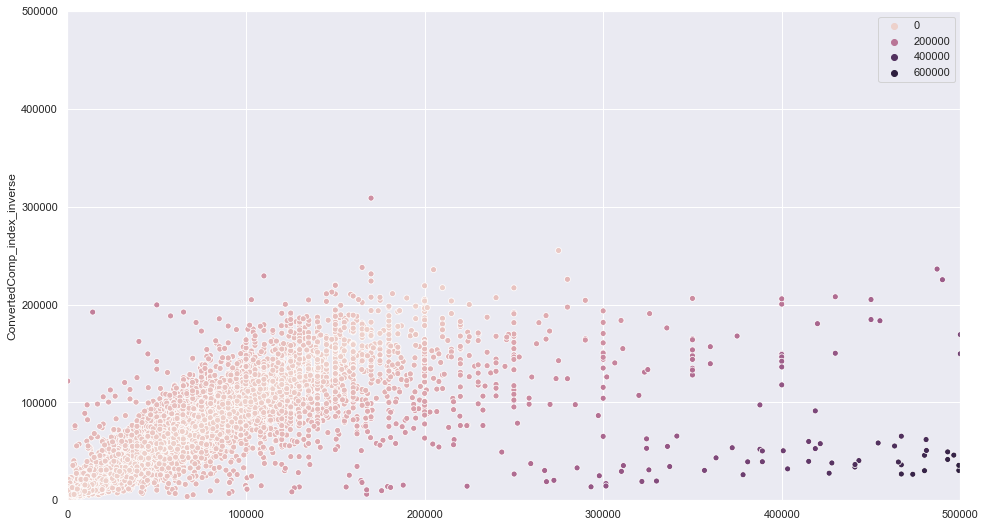

In [35]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
plt.show()

In [39]:
results = run(exclude_columns=None, name="With Agg Features",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
             transform_target=True)

With Agg Features
Target Transformed


In [40]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features
RandomForestRegressor,0.135633,9558.700886,325787.451298,0.828815,0.719737,22031.170301,4.476165e+05,0.463140,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",372,2206 125000.0 8495 110000.0 9692 1160...,2206 114532.922367 8495 120227.628489 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
LassoCV,0.749648,23080.896540,449961.041123,0.433218,0.788847,23337.849063,4.543928e+05,0.426144,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",372,2206 125000.0 8495 110000.0 9692 1160...,2206 121528.264110 8495 98087.944904 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
RidgeCV,0.723942,23343.064414,450165.821127,0.431991,0.798428,23705.957279,4.558372e+05,0.418745,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",372,2206 125000.0 8495 110000.0 9692 1160...,2206 130976.588604 8495 98419.695497 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
LinearSVR,0.846520,27329.747282,464105.876547,0.308480,0.815660,27415.055559,4.673388e+05,0.319082,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",372,2206 125000.0 8495 110000.0 9692 1160...,2206 116825.167636 8495 103123.584524 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
DecisionTreeRegressor,0.000006,0.394928,134.620724,1.000000,1.204886,40096.744260,1.836067e+06,-1.016503,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",372,2206 125000.0 8495 110000.0 9692 1160...,2206 1.613591e+05 8495 1.527780e+05 9692...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."


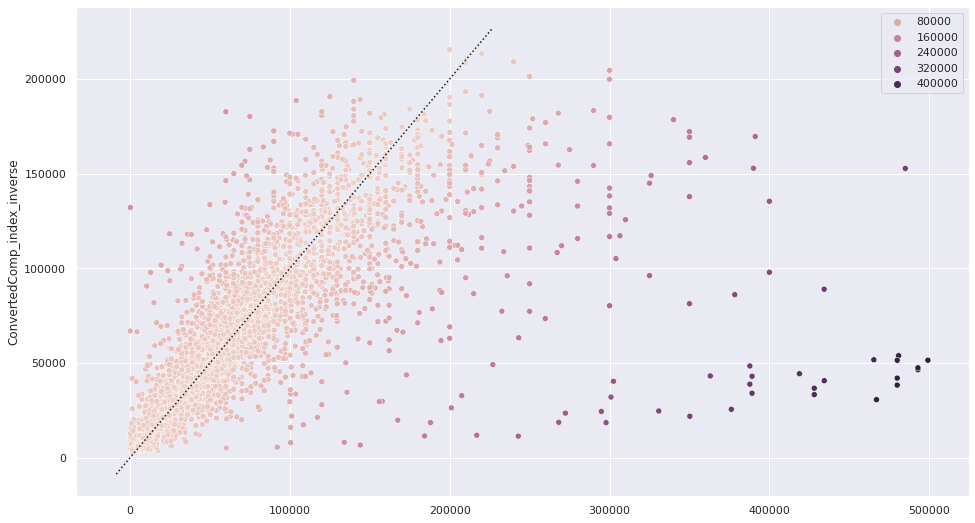

In [41]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')
plt.show()

In [42]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
             transform_target=True)

With Agg Features + relevant tech groups
Target Transformed


In [43]:
results

,mape_train,mean_absolute_error_train,max_error_train,r2_score_train,mape_test,mean_absolute_error_test,max_error_test,r2_score_test,model_object,num_feat,y_true_test,y_pred_test,features
RandomForestRegressor,0.136465,9607.486944,332150.923573,0.829906,0.722942,22115.320893,4.459289e+05,0.461206,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",395,2206 125000.0 8495 110000.0 9692 1160...,2206 105333.415661 8495 121224.593144 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
LassoCV,0.749026,23061.723011,450746.805514,0.433395,0.792264,23294.581253,4.553618e+05,0.426010,"LassoCV(alphas=None, copy_X=True, cv=None, eps...",395,2206 125000.0 8495 110000.0 9692 1160...,2206 124139.561002 8495 98072.584610 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
RidgeCV,0.731377,23326.282312,452007.592500,0.432037,0.803306,23641.738677,4.576267e+05,0.419316,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",395,2206 125000.0 8495 110000.0 9692 1160...,2206 132732.821513 8495 99863.885507 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
LinearSVR,0.847853,28526.868510,457786.057140,0.305271,0.856601,28309.594883,4.545852e+05,0.311412,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",395,2206 125000.0 8495 110000.0 9692 1160...,2206 118864.382007 8495 78881.218296 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
DecisionTreeRegressor,0.000007,0.402841,134.620724,1.000000,1.201811,38553.980427,1.509101e+06,-0.711347,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",395,2206 125000.0 8495 110000.0 9692 1160...,2206 77000.000000 8495 125172.655789 96...,"Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."


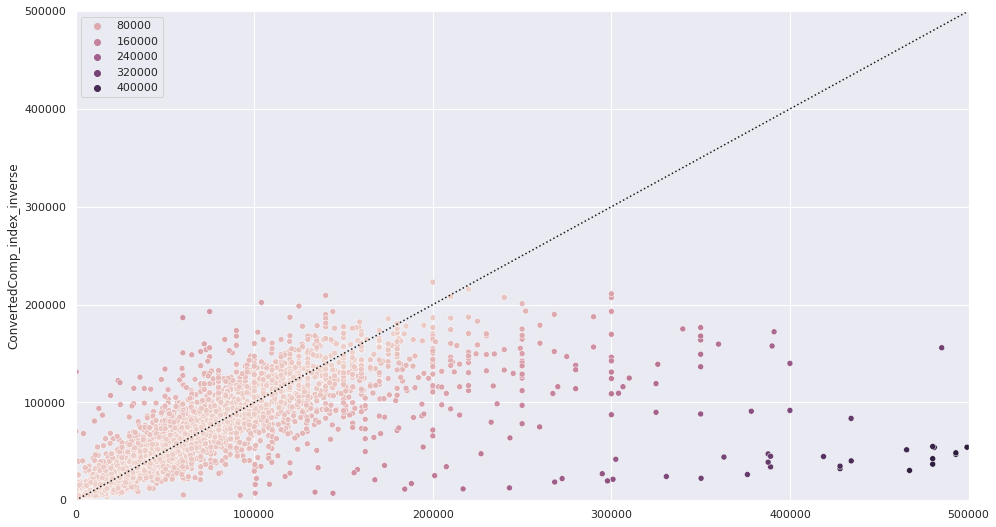

In [44]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')
plt.show()

In [45]:
experiment_list.sort_values("mape_test")

,mean_absolute_error_train,mape_train,mean_absolute_error_test,mape_test,index,num_feat,model_object,features
With Agg Features,9558.700886,0.135633,22031.170301,0.719737,RandomForestRegressor,372,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
Initial Run,9519.691840,0.135481,21885.679738,0.719934,RandomForestRegressor,572,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
With Agg Features + relevant tech groups,9607.486944,0.136465,22115.320893,0.722942,RandomForestRegressor,395,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...","Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."
Initial Run w/o target transformation,24823.743702,1.138384,25214.477497,1.155072,LassoCV,572,"LassoCV(alphas=None, copy_X=True, cv=None, eps...","Index(['Age', 'Age1stCode', 'WorkWeekHrs', 'Ye..."


In [23]:
results = run(name="Initial Run + Feat Selection", feture_elimination_num_feat="auto", transform_target=True)
results

Initial Run + Feat Selection
Target Transformed


KeyboardInterrupt: 

In [ ]:
results = run(exclude_columns=None, name="With Agg Features + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=False,
             feture_elimination_num_feat="auto",
             transform_target=True)
results

In [ ]:
results = run(exclude_columns=None, name="With Agg Features + relevant tech groups + Feat Selection",
              feat_agg_calculate_chosen_options_ratio=True,
             feat_agg_worked_with_high_and_low_leverage=True,
              feat_agg_worked_with_relevant_tech=True,
             feture_elimination_num_feat="auto",
             transform_target=True)
results

In [ ]:
y_true_test = results.iloc[0, results.columns.get_loc("y_true_test")]
y_pred_test = results.iloc[0, results.columns.get_loc("y_pred_test")]

ax = sns.scatterplot( x=y_true_test, y=y_pred_test, hue=np.abs(y_true_test-y_pred_test) )
ax.set(ylim=(0, 500000))
ax.set(xlim=(0, 500000))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
ax.plot(lims, lims, ':k')

plt.show()

In [ ]:
experiment_list.sort_values("mape_test")